# Imports

In [37]:
from lxml import etree
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim.utils import simple_preprocess
import gensim.similarities 
from gensim.models.word2vec import Word2Vec
import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy import spatial
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import csv
from numpy import asarray
from numpy import savetxt
import matplotlib.pyplot as plt

# Pre-Processing

In [38]:
# reads in the CVE data sets and returns vulnerability information  

def read_files(files):
    all_entries = {0: {'CVE': "", 'Date': "",'Description': [], 'Description-Tokenized' : [],
                   'Month-String':"",'Month-Int': 0,"Year":"","Year-Int":0,"Cluster": 0,
                    "Time Start": 0, "Time End": 0}}
    
    untokenized_text = list()
    start_index = 0
    year_num = 1
    
    for file in files:
        vulns = parse_data(file)
        for text in vulns[1]:
            untokenized_text.append(text)
        cur_entries = store_entries(vulns,start_index,year_num,len(files))
        start_index = len(cur_entries) + start_index
        all_entries = all_entries | cur_entries
        year_num = year_num + 1
        
    return [all_entries,untokenized_text] 
        
# helper method used to identify "REJECT" entries 

def is_member(target, possible):
    for item in possible:
        if target is item or target == item:
              return True
    return False

# parse CVE dataset in a hierarchical format

def parse_data(file):
    tree = ET.parse(file)
    root = tree.getroot()
    notes = list()
    cve = list()
    pub = list()
    for i in range(5,len(root)):
        try:
            token = word_tokenize(root[i][1][0].text)
            if is_member("REJECT",token) == False:  
                pub.append(root[i][1][1].text)
                cve.append(root[i][2].text)
                notes.append(root[i][1][0].text)
        except:
            continue
    
    vulns_info = [cve,notes,pub]
    return vulns_info
            
# methods for tokenizing     
    
def tokenize(text):
    tokenized = list()
    for i in range(0, len(text)):
        filtered = remove_stopwords(word_tokenize(text[i]))
        tokenized.append(filtered)
                         
    return tokenized

def tokenize_single(sentence):
    filtered = remove_stopwords(word_tokenize(sentence))
    tokenized = [word.lower() for word in filtered] 
    return tokenized

# method to remove stopwords and punctuation

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    stop_words.append(')')
    stop_words.append('(')
    stop_words.append('.')
    stop_words.append('')
    filtered_sentence = [w for w in text if not w.lower() in stop_words]
    filtered_sentence = []
 
    for w in text:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

# read vulnerability text for doc2vec model training 

def read_corpus(text, tokens_only=False):
    count=0
    for doc in text:
        count+=1
        tokens = gensim.utils.simple_preprocess(doc)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [count])

            
# build and train a doc2vec model on all vulnerability text          
            
def build_doc2vec(untokenized_text):
    train_corpus = list(read_corpus(untokenized_text))
    test_corpus = list(read_corpus(untokenized_text, tokens_only=True))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=20)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    return model


# converts the vulnerability text to vectors. text is a list of tokenized sentences for the entire data set
# model is a doc2vec model 
 
def compute_vectors(text,model):
    vectors = list()
    for sentence in text:
        vectors.append(model.infer_vector(sentence))
    return vectors
        
    
# store information of each vulnerability entry in a dictionary. Includes CVE ID, Publication date, vulnerability
# description, tokenized description, month as a string, and month as an int (1-12)
    
def store_entries(vulns,start_index,year_num,total_years):
    # Create dictionaries for every year 
    entries = {start_index: {'CVE': "", 'Date': "",'Description': [], 'Description-Tokenized' : [],
                   'Month-String':"",'Month-Int': 0,"Year":"","Year-Int":0,"Time Start": 0, "Time End": 0}}
    j=0

    for i in range(start_index,start_index+len(vulns[0])):
        entries[i] = {}
        entries[i]['CVE'] = vulns[0][j]
        entries[i]['Date'] = vulns[2][j]
        entries[i]['Description'] = vulns[1][j]
        tokenized = tokenize_single(vulns[1][j])
        desc_tokenized = remove_stopwords(tokenized)
        entries[i]['Description-Tokenized'] = desc_tokenized
        entries[i]['Month-String'] = "n/a"
        entries[i]['Month-Int'] = 0
        entries[i]["Year"] = entries[i]['Date'][0:4]
        entries[i]["Year-Int"] = year_num
        j = j + 1

    for i in range(start_index,start_index+len(vulns[0])):
        if str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '1':
            entries[i]["Month-String"] = "January"
            entries[i]["Month-Int"] = 1
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '2':
            entries[i]["Month-String"] = "February"
            entries[i]["Month-Int"] = 2
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '3':
            entries[i]["Month-String"] = "March"
            entries[i]["Month-Int"] = 3
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '4':
            entries[i]["Month-String"] = "April"
            entries[i]["Month-Int"] = 4
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '5':
            entries[i]["Month-String"] = "May"
            entries[i]["Month-Int"] = 5
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '6':
            entries[i]["Month-String"] = "June"
            entries[i]["Month-Int"] = 6
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '7':
            entries[i]["Month-String"] = "July"
            entries[i]["Month-Int"] = 7
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '8':
            entries[i]["Month-String"] = "August"
            entries[i]["Month-Int"] = 8
        elif str(entries[i]['Date'])[5] == '0' and entries[i]['Date'][6] == '9':
            entries[i]["Month-String"] = "September"
            entries[i]["Month-Int"] = 9
        elif str(entries[i]['Date'])[5] == '1' and entries[i]['Date'][6] == '0':
            entries[i]["Month-String"] = "October"
            entries[i]["Month-Int"] = 10
        elif str(entries[i]['Date'])[5] == '1' and entries[i]['Date'][6] == '1':
            entries[i]["Month-String"] = "November"
            entries[i]["Month-Int"] = 11
        else:
            entries[i]["Month-String"] = "December"
            entries[i]["Month-Int"] = 12
        
        # get time interval 
        entries[i]["Time Start"] = (year_num * 12) - entries[i]["Month-Int"]
        entries[i]["Time End"] = total_years * 12
        
    return entries

# Networks

In [39]:

# creates an inverse cosine matrix 

def create_cos_matrix(vectors):
    length = len(vectors)
    matrix = np.zeros((length, length))
    row_means =list() 
    for i in range(0,length):
        for j in range(i,length):
            mean = 0
            dist = spatial.distance.cosine(vectors[i], vectors[j])
            cos = abs(1/(1-dist))
            
            #cos = abs(1/(1-spatial.distance.cosine(vectors[i], vectors[j])))
            matrix[i][j] = cos
            matrix[j][i] = cos 
            mean +=cos
        
            if(cos == 1):
                matrix[i][j] = 999
                matrix[j][i] = 999
        mean = mean/length
        row_means.append(mean)
        
    for i in range(0,length):
        for j in range(i,length):
            if  matrix[i][j] < row_means[i]:
                matrix[i][j] = 0
                matrix[j][i] = 0 
                
    return matrix
                
# create a networkx graph from a cosine matrix 
    
def create_network(cos_matrix):
    X = sparse.csr_matrix(cos_matrix)
    Tcsr = minimum_spanning_tree(X)
    arr = Tcsr.toarray().astype(float)
    G = nx.from_numpy_array(arr, parallel_edges=False, create_using=None)
    return G

    
# convert networkx network to an igraph

def create_igraph(G, entries,subnetwork = False):
    # convert to igraph
    h = ig.Graph.from_networkx(G)
    weights_i = h.es["weight"]
    
    if subnetwork == True:
        return h
    
    spanning_tree = h.spanning_tree(weights=weights_i, return_tree=True)
    start_times = list()
    end_times = list()
    for i in range(0,len(entries)):
        start_times.append(entries[i]['Time Start'])
        end_times.append(entries[i]['Time End'])
        
    spanning_tree.vs["start_time"] = start_times
    spanning_tree.vs["end_time"] = end_times
    
    edge_times = list()
    for edge in spanning_tree.es:
        target_vertex_id = edge.target
        edge_times.append(entries[target_vertex_id]['Time Start'])
    
    spanning_tree.es["start_time"] = edge_times
    spanning_tree.es["end_time"] = end_times

    return spanning_tree
    
    
# write edge attributes to a csv file 

def edge_list_to_csv(I,filename):
    row_list = [["start_time","end_time","source","target",'weight']]
    
    for edge in I.es:
        source = edge.source
        target = edge.target
        cur = [edge['start_time'],edge['end_time'],source,target,edge['weight']]
        row_list.append(cur)
        
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(row_list)
        
# write edge attributes to a csv file 

def node_list_to_csv(I,filename):
    row_list = [["id","start_time","end_time"]]
    for node in I.vs:
        row_list.append([node['_nx_name'],node['start_time'],node['end_time']])
        
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(row_list)

# Histograms

In [40]:
vuln_types = {'Buffer Overflow': ['overflow'], 'Buffer Underflow': ['underflow'], 'Injection': ['injection'], 
              'Broken Authentication': ['authentication'], 
              'XSS': ['XSS','scripting','xss'], 'SSRF': ['server','SSRF','ssrf'], 'CSRF': ['cross','CSRF','csrf'], 
              'Null Pointer Deference': ['pointer'],
              'Out of Bounds': ['bounds'], 'Directory/path Traversal': ['path','directory','traversal'], 
              'Sensitive Data Exposure': ['sensitive'], 'Elevation Priveleges': ['elevation'], 
              'Spoofing': ['spoofing','spoof'], 'Denial of Service': ['denial','service'], 
              'Bypass Restrictions': ['bypass'], 'Broken Access Control': ['access'],
              'Unauthorized Access': ['privileged'],'FTP Issues': ['FTP'],'XML External Entities':['external','xml','XML'],
              'Integer Overflow':['integer'], 'Improper Initialization':['initialization'],
              'Improper Sanitaization':['sanitization'],'Improper Neutralization':['neutralization'],
             'SSL Isssues':['SSL','sockets','ssl'],'Heap Overflow':['heap']}

In [41]:
len(vuln_types)

25

In [42]:
def split_by_month(entries):
    split = []
    for i in range(0,72):
        split.append([])
    
    for i in range(0,len(entries)):
        month = entries[i]['Time Start']
        split[month-1].append(entries[i]['Description-Tokenized'])
        
    return split

def split_by_year(entries,file_length):
    split = []
    for i in range(0,len(files)):
        split.append([])
    
    for i in range(0,len(entries)):
        year = entries[i]["Year-Int"]
        split[year-1].append(entries[i]['Description-Tokenized'])
        
    return split


def get_col(month): 
    col = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    row = 0
    for vuln in month:
        for word in vuln:
            for key,value in vuln_types.items():
                if is_member(word,value):
                    col[row] = 1
                row+=1
            row = 0
    return col


def create_indicator_matrix(entries):
    months = split_by_month(entries)
    indic_matrix = np.zeros((24, 72))
    col = 0
    
    for month in months:
        for i in range(0,24):
            indic_matrix[i][col] = get_col(month)[i]
        col += 1
 
    return indic_matrix 

def count_occurrences(year_entries):
    occur = {'Buffer Overflow': 0, 'Buffer Underflow': 0, 'Injection': 0, 'Broken Authentication': 0, 
              'XSS': 0, 'SSRF': 0, 'CSRF': 0, 'Null Pointer Deference': 0,
              'Out of Bounds': 0, 'Directory/path Traversal': 0,'Sensitive Data Exposure': 0, 
              'Elevation Priveleges': 0, 'Spoofing': 0, 'Denial of Service': 0, 
              'Bypass Restrictions': 0, 'Broken Access Control': 0,'Unauthorized Access': 0,'FTP Issues':0,
            'XML External Entities':0,'Integer Overflow':0, 'SSRF':0,'Improper Initialization':0,
              'Improper Sanitaization':0,'Improper Neutralization':0,'SSL Isssues':0,'Heap Overflow':0}

    for i in range(0,len(year_entries)):
        vuln = year_entries[i]
        for key,value in vuln_types.items():
            for word in value:
                if is_member(word,vuln):
                    occur[key] = occur[key] + 1
    return occur


# years is list of strings, vuln_types_length is int  
# adjust year_label and the plot title according to years being analyzed
def create_vuln_histogram(entries,vuln_types_length,years):
    year_label = [1999,2000,2001,2002,2003,2004]
    #year_label = [2005,2006,2007,2008,2009,2010]
    #year_label = [2011,2012,2013,2014,2015,2016]
    #year_label = [2017,2018,2019,2020,2021]
    # set width of bar
    barWidth = 0.1
    fig = plt.subplots(figsize =(12, 8))
    vuln_types_length = len(vuln_types)
    
    # Set position of bar on X axis
    br = np.arange(vuln_types_length)
    
    years_split = split_by_year(entries,years)

    for i in range(0,years):
        cur = count_occurrences(years_split[i])
        plt.bar(br, [value for key,value in cur.items()], width = barWidth, edgecolor ='grey', label = year_label[i])
        # Set position of bar on X axis
        br = [barWidth+ x  for x in br]
    
    # Adding Xticks
    plt.xlabel('Vulnerability Type', fontweight ='bold', fontsize = 15)
    plt.ylabel('Number of Occurrences', fontweight ='bold', fontsize = 15)
    plt.xticks((range(vuln_types_length)), [key for key,value in vuln_types.items()], rotation = 80)
    plt.title("Distribution of Vulnerability Occurrences From 1999-2004")
    plt.legend()
    plt.show()
    

# Main Method

## 1999-2004

In [43]:
# Ask user for filename of the node and edge attributes to be analyzed 

#dataset_filename = str(input("Enter the name of the dataset file you would like to analyze: "))
files = ['/CVEDatasSets/allitems-cvrf-year-1999.xml',
        '/CVEDatasSets/allitems-cvrf-year-2000.xml',
        '/CVEDatasSets/allitems-cvrf-year-2001.xml',
        '/CVEDatasSets/allitems-cvrf-year-2002.xml',
        '/CVEDatasSets/allitems-cvrf-year-2003.xml',
        '/CVEDatasSets/allitems-cvrf-year-2004.xml']

In [44]:
def main(files):
    file_info = read_files(files)
    entries = file_info[0]
    text = file_info[1]
    years = len(files)

    return [entries,years]
output = main(files)

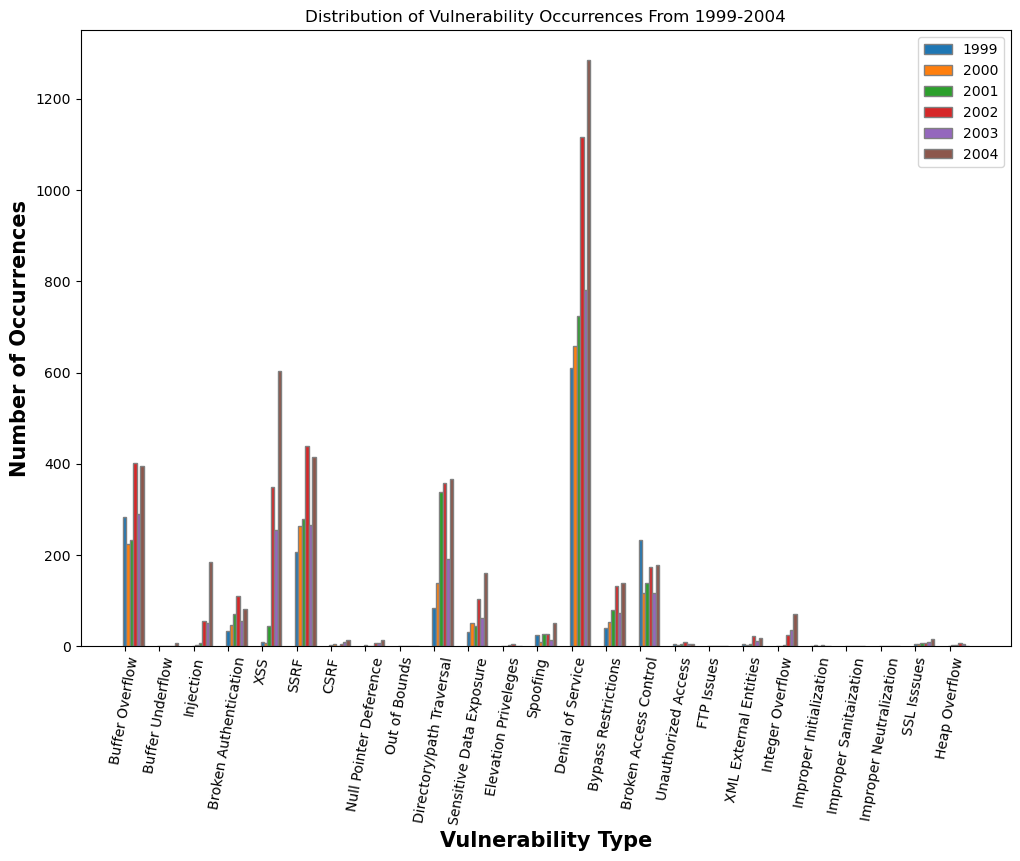

In [47]:
create_vuln_histogram(output[0],len(vuln_types),output[1])

## 2005-2010

In [25]:
files = ['/CVEDatasSets/allitems-cvrf-year-2005.xml',
        '/CVEDatasSets/allitems-cvrf-year-2006.xml',
        '/CVEDatasSets/allitems-cvrf-year-2007.xml',
        '/CVEDatasSets/allitems-cvrf-year-2008.xml',
        '/CVEDatasSets/allitems-cvrf-year-2009.xml',
        '/CVEDatasSets/allitems-cvrf-year-2010.xml']

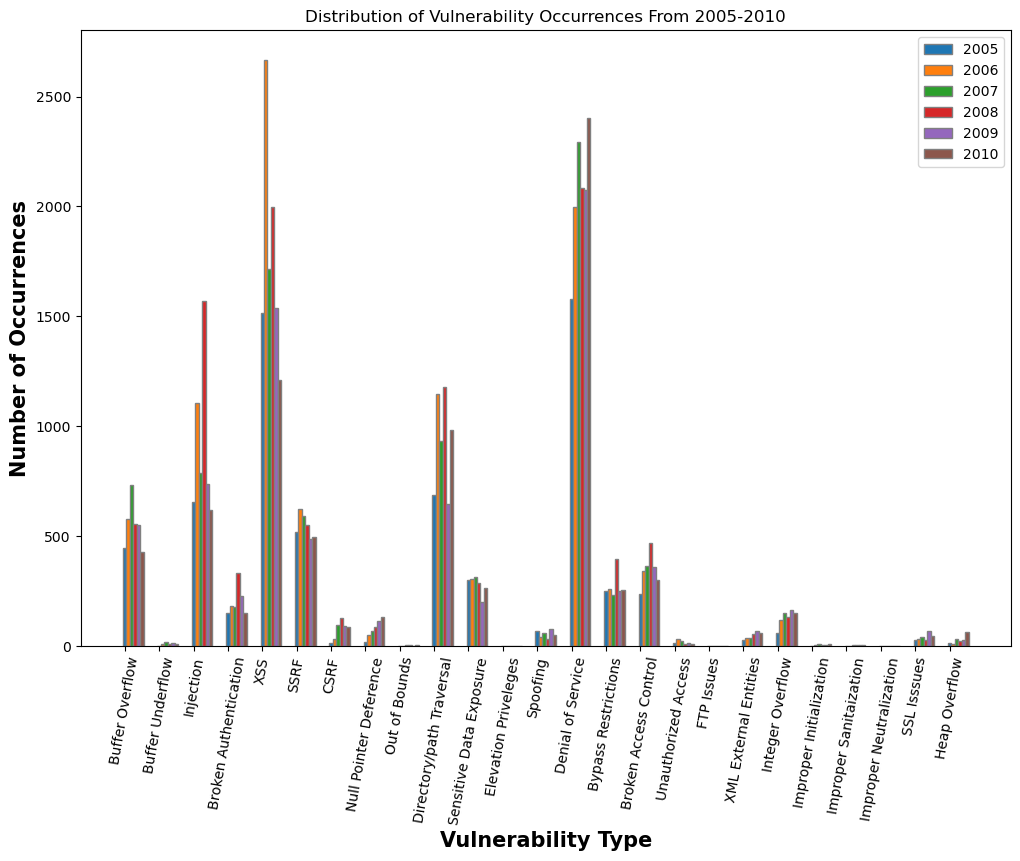

In [26]:
output = main(files)
create_vuln_histogram(output[0],len(vuln_types),output[1])

## 2011-2016

In [28]:
files = ['/CVEDatasSets/allitems-cvrf-year-2011.xml',
        '/CVEDatasSets/allitems-cvrf-year-2012.xml',
        '/CVEDatasSets/allitems-cvrf-year-2013.xml',
        '/CVEDatasSets/allitems-cvrf-year-2014.xml',
        '/CVEDatasSets/allitems-cvrf-year-2015.xml',
        '/CVEDatasSets/allitems-cvrf-year-2016.xml']

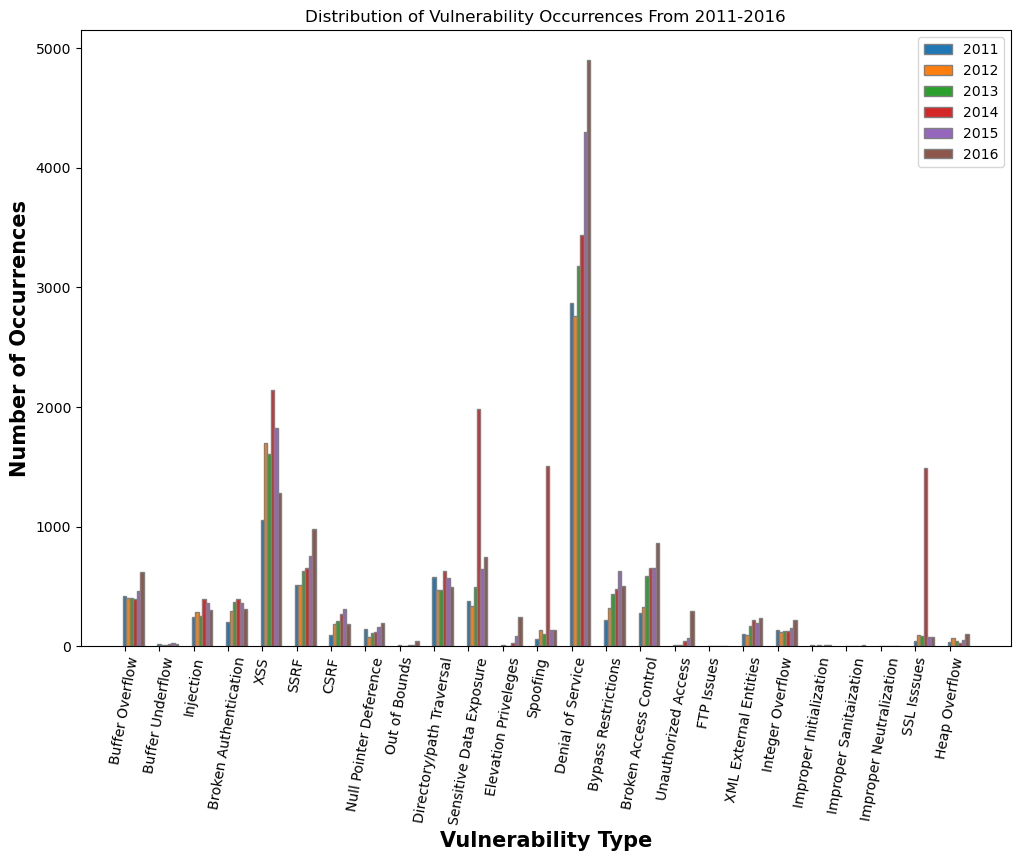

In [29]:
output = main(files)
create_vuln_histogram(output[0],len(vuln_types),output[1])

## 2017-2021

In [31]:
files = ['/CVEDatasSets/allitems-cvrf-year-2017.xml',
        '/CVEDatasSets/allitems-cvrf-year-2018.xml',
        '/CVEDatasSets/allitems-cvrf-year-2019.xml',
        '/CVEDatasSets/allitems-cvrf-year-2020.xml',
        '/CVEDatasSets/allitems-cvrf-year-2021.xml']

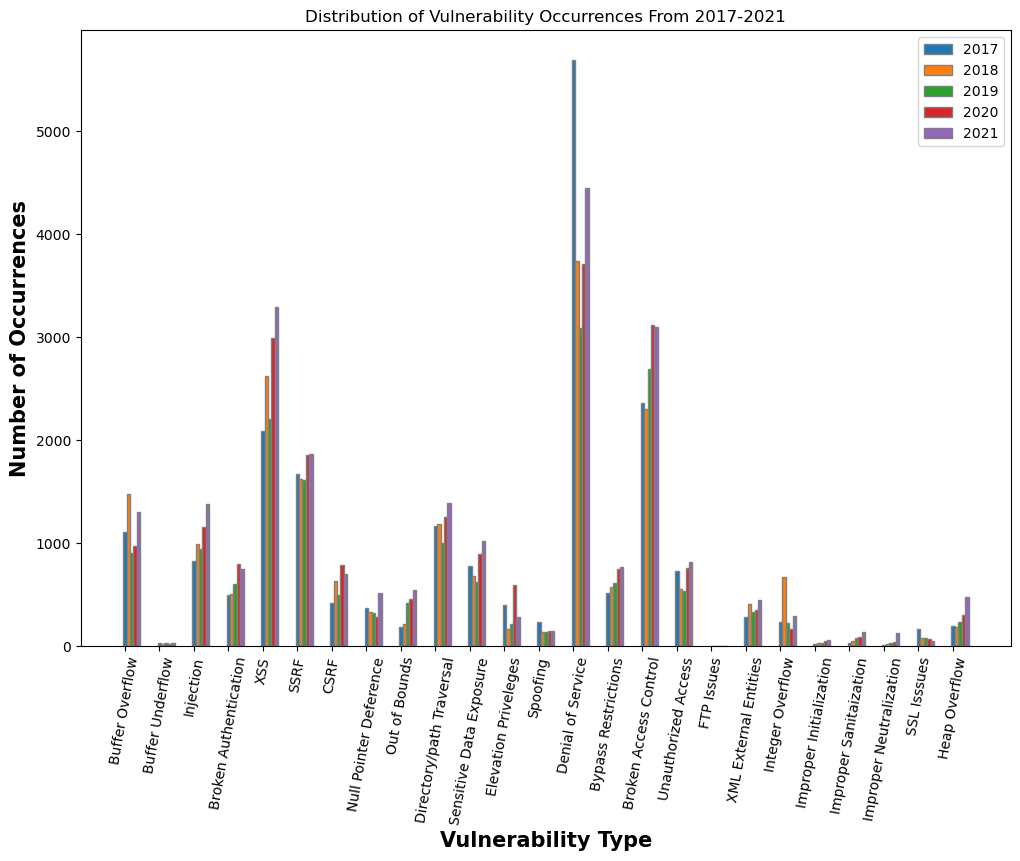

In [32]:
output = main(files)
create_vuln_histogram(output[0],len(vuln_types),output[1])